In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model
from keras.layers import Dense, Activation, LSTM, GRU, Input, concatenate
from keras.optimizers import Adam
from keras.engine.topology import Layer
from keras import backend as K

Using TensorFlow backend.


In [2]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(** kwargs)

    def build(self, input_shape):
        assert len(input_shape)==3
        # W.shape = (time_steps, time_steps)
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[1], input_shape[1]),
                                 initializer='uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias', 
                                 shape=(input_shape[1],),
                                 initializer='uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs.shape = (batch_size, time_steps, seq_len)
        x = K.permute_dimensions(inputs, (0, 2, 1))
        # x.shape = (batch_size, seq_len, time_steps)
        a = K.softmax(K.tanh(K.dot(x, self.W) + self.b))
        outputs = K.permute_dimensions(a * x, (0, 2, 1))
#         outputs = K.sum(outputs, axis=1)
        return outputs

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], input_shape[2]

In [9]:
import pandas as pd
df = pd.read_csv('data_python.csv')
df.head()
T2 = df['Y0']
T_new = []
for i in range(1600):
    tmp = [0] * 9
    tmp.extend(T2[i * 146: (i + 1)* 146])
    for j in range(len(tmp) - 10):
        T_new.append(tmp[j: j + 10])
T_new = np.array(T_new)
u1 = df['U1']
u2 = df['U2']
y1 = df['Y1']
y2 = df['Y2']
a1 = df['A1']
a2 = df['A2']
train_data = []
target = []
for i in range(1600):
    tmp = np.array([0] * 9)
    u1_tmp = np.hstack((tmp, u1[i * 146: (i + 1)* 146]))
    u2_tmp = np.hstack((tmp, u2[i * 146: (i + 1)* 146]))
    y1_tmp = np.hstack((tmp, y1[i * 146: (i + 1)* 146]))
    y2_tmp = np.hstack((tmp, y2[i * 146: (i + 1)* 146]))
    a1_tmp = np.hstack((tmp, a1[i * 146: (i + 1)* 146]))
    a2_tmp = np.hstack((tmp, a2[i * 146: (i + 1)* 146]))
    target.extend(T2[i * 146 + 1: (i + 1)* 146])
    for j in range(len(u1_tmp) - 10):
        train_data.append(np.hstack((u1_tmp[j: j + 10], u2_tmp[j: j + 10],
                                     y1_tmp[j: j + 10], y2_tmp[j: j + 10],
                                     a1_tmp[j: j + 10], a2_tmp[j: j + 10])))
train_data = np.array(train_data)
target = np.array(target).reshape(232000, 1)

In [11]:
# T = np.load('python_train_target.csv.npy').reshape(233600, 1)
# P = np.load('python_train_data.csv.npy')
# P_T = np.load('python_train_data_Y0.csv.npy')
T = target
P = train_data
P_T = T_new
print(T.shape, P.shape, P_T.shape)
train_num = int(P.shape[0] * 0.8)
test_num = int(P.shape[0] * 0.2)
P_Train = P[:train_num, :]
T_Train = T[:train_num, :]
P_Test = P[train_num:, :]
T_Test = T[train_num:, :]
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
stdsc = StandardScaler()
P_Train = stdsc.fit_transform(P_Train)
P_Test = stdsc.transform(P_Test)
joblib.dump(stdsc, "stdsc_python.m")
P_Train = P_Train.reshape(train_num,1,60)
P_Test = P_Test.reshape(test_num,1,60)
T_new_Train = P_T[:train_num, :]
T_new_Test = P_T[train_num:, :]
T_new_Train = T_new_Train.reshape(train_num,1,10)
T_new_Test = T_new_Test.reshape(test_num,1,10)

(232000, 1) (232000, 60) (232000, 10)


In [12]:
inputs = Input(shape=(1, 60))
gru1 = GRU(units=16, recurrent_dropout=0.2, activation="tanh", return_sequences=True)(inputs)
gru2 = GRU(units=8, recurrent_dropout=0.2, activation="relu", return_sequences=True)(gru1)
attenetion = AttentionLayer()(gru2)
T_input = Input(shape=(1, 10))
gru4 = GRU(units=8, recurrent_dropout=0.2, activation="tanh", return_sequences=True)(T_input)
x = concatenate([attenetion, gru4], axis=1)
gru4 = GRU(units=4, recurrent_dropout=0.2, activation="tanh")(x)
x = Dense(16, activation='relu')(gru4)
main_output = Dense(1, name='main_output')(x)
model = Model(inputs=[inputs, T_input], outputs=main_output)

In [13]:
model.compile(loss='mse', optimizer='adam')
history = model.fit([P_Train, T_new_Train], T_Train, batch_size=146, epochs=50,
                    validation_data=([P_Test,T_new_Test], T_Test))

Train on 185600 samples, validate on 46400 samples
Epoch 1/50
185600/185600 [==============================] - 13s 69us/step - loss: 2.0799e-05 - val_loss: 1.2193e-06
Epoch 2/50
185600/185600 [==============================] - 9s 48us/step - loss: 7.6848e-07 - val_loss: 9.1928e-07
Epoch 3/50
185600/185600 [==============================] - 9s 49us/step - loss: 4.3645e-07 - val_loss: 4.0670e-07
Epoch 4/50
185600/185600 [==============================] - 9s 50us/step - loss: 3.6138e-07 - val_loss: 2.6498e-07
Epoch 5/50
185600/185600 [==============================] - 9s 47us/step - loss: 2.8688e-07 - val_loss: 4.2606e-07
Epoch 6/50
185600/185600 [==============================] - 9s 49us/step - loss: 2.6780e-07 - val_loss: 2.4168e-07
Epoch 7/50
185600/185600 [==============================] - 8s 46us/step - loss: 2.3413e-07 - val_loss: 2.1972e-07
Epoch 8/50
185600/185600 [==============================] - 9s 47us/step - loss: 2.1213e-07 - val_loss: 1.7298e-07
Epoch 9/50
185600/185600 [==

In [14]:
pred = model.predict([P_Test, T_new_Test])

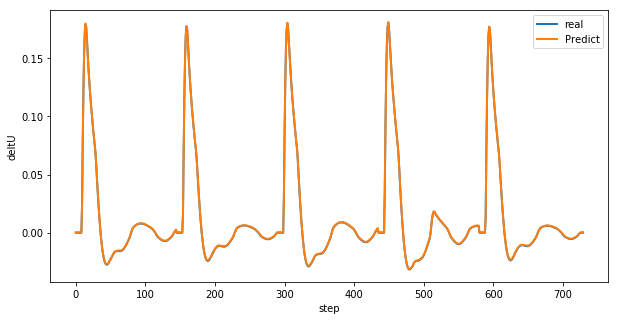

In [15]:
plt.figure(figsize=(10,5))
plt.plot(T_Test[0:730], linewidth=2, label='real')
plt.plot(pred[0:730], linewidth=2, label='Predict')
plt.xlabel('step')
plt.ylabel('deltU')
plt.legend()
plt.show()

In [16]:
model.save('encoder_decoder_gru_python_data_145.h5')

In [17]:
a = [1,2,3,4]